In [1]:
import numpy as np
import pandas as pd
import torch
from typing import Optional, Literal, Union
import matplotlib.pyplot as plt

# we use a local copy of the fast_soft_sort manually downloaded from
# https://github.com/google-research/fast-soft-sort/tree/master
from fast_soft_sort.pytorch_ops import soft_rank

## Test ordinary lr in torch

Data generating model and data:

In [2]:
def generate_data(n_features: int, n_samples: int) -> tuple[object, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate data."""
    torch.manual_seed(0)

    # the true data generating model
    model_true = torch.nn.Linear(n_features, 1)

    # For the simplicity of the analysis, set the model params
    # to the numbers running from 1 through (n_features + 1).
    with torch.no_grad():
        i = 1
        for name, param in model_true.named_parameters():
            param.copy_(torch.arange(i, i + param.numel()))
            i += param.numel()
            param.requires_grad = False

    # Generate training and test data.
    X_train = torch.rand((n_samples, n_features))
    y_train = model_true(X_train)

    X_test = torch.rand((n_samples // 10, n_features))
    y_test = model_true(X_test)
    return model_true, X_train, y_train, X_test, y_test

In [3]:
n_features = 3
n_samples = 1000

Help funcs:

In [16]:
def init_model(n_features: int, lr: float, weight_decay: float) -> tuple[object, object]:
    """Initialize model.
        Params:
            n_features: number of features the model will have
            lr: learning rate
            weight_decay: L2 regularization strength
        Return:
            initialized model and optimizer
    """
    model = torch.nn.Linear(n_features, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, optimizer

def train_step(X: torch.Tensor, y: torch.Tensor, model: object, loss_fn: object, optimizer: object) -> torch.Tensor:
    """Make one training step."""
    # Compute prediction and loss
    y_hat = model(X)
    loss = loss_fn(y, y_hat)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # did not forget!

    return loss

def train(
        X_train: torch.Tensor,
        y_train: torch.Tensor,
        X_test: torch.Tensor,
        y_test: torch.Tensor,
        n_features: int,
        n_steps: int,
        lr: float,
        weight_decay: float,
        loss_fn: object,
        eval_fn: object
        ) -> tuple[object, pd.DataFrame]:
    """Train LR model."""
    model, optimizer = init_model(n_features, lr=lr, weight_decay=weight_decay)

    stats = {"training loss": [], "test loss": [], "training eval": [], "test eval": []}
    for _ in range(n_steps):
        train_loss = train_step(X_train, y_train, model, loss_fn, optimizer)
        test_loss = loss_fn(y_test, model(X_test))
        train_eval = eval_fn(y_train, model(X_train))
        test_eval = eval_fn(y_test, model(X_test))
        stats["training loss"].append(train_loss.item())
        stats["test loss"].append(test_loss.item())
        stats["training eval"].append(train_eval.item())
        stats["test eval"].append(test_eval.item())

    return model, pd.DataFrame(stats)

def rank(y: torch.Tensor) -> torch.Tensor:
    "Rank real numbers."
    r = torch.empty_like(y)
    r[y.argsort(dim=0), 0] = torch.arange(1, y.numel() + 1, dtype=y.dtype).reshape(-1, 1)
    return r

############################### Loss funcs ###############################
def loss_mse(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """MSE loss."""
    criterion = torch.nn.MSELoss()
    return criterion(y, y_hat)

def loss_msrd(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    "Mean squared soft rank difference loss."
    # rank true values
    r = rank(y)
       
    # soft rank predictions
    r_hat = soft_rank(y_hat.reshape(1, -1), regularization_strength=0.001).reshape(-1, 1)
    
    # normalize ranks
    r = (r - 1) / (r.numel() - 1)
    r_hat = (r_hat - 1) / (r_hat.numel() - 1)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    loss = criterion(r, r_hat)

    return loss

############################### Metrics ###############################
def eval_msrd(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """Mean squared exact rank difference metric."""
    # exact rank true values
    r = rank(y)
       
    # exact rank predictions
    r_hat = rank(y_hat)
    
    # normalize ranks
    r = (r - 1) / (r.numel() - 1)
    r_hat = (r_hat - 1) / (r_hat.numel() - 1)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    eval = criterion(r, r_hat)

    return eval

def eval_spearman(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """(exact) Spearman corr metric"""
    y = y.reshape(1, -1).squeeze().numpy()
    y_hat = y_hat.reshape(1, -1).squeeze().detach().numpy()
    eval = pd.DataFrame({"y": y, "y_hat": y_hat}).corr("spearman").iloc[0, 1]
    return torch.tensor(eval)

## Objective: MSE, eval: MSE

In [5]:
model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples)

# check that model params have been set correctly
for name, param in model_true.named_parameters():
    print(name, param)

model, stats = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=3000,
        lr=1e-2,
        weight_decay=0.0,
        loss_fn=loss_mse,
        eval_fn=loss_mse
        )

weight Parameter containing:
tensor([[1., 2., 3.]])
bias Parameter containing:
tensor([4.])


Learning curve:

<Axes: >

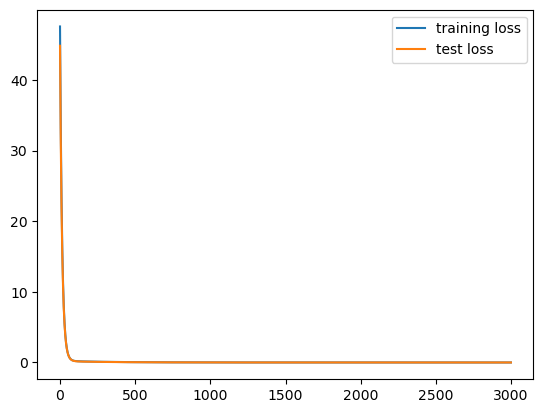

In [6]:
stats.iloc[:, :2].plot()

Model params that have been learned:

In [7]:
for name, param in model.named_parameters():
    print(f"{name}:\t{param}")

weight:	Parameter containing:
tensor([[1.0103, 2.0036, 2.9953]], requires_grad=True)
bias:	Parameter containing:
tensor([3.9953], requires_grad=True)


## Objective: MSRD, eval: exact MSRD

In [8]:
model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples)

model, stats = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=3000,
        lr=1e-2,
        weight_decay=0.0,
        loss_fn=loss_msrd,
        eval_fn=eval_msrd
        )

Learning curves:

<Axes: >

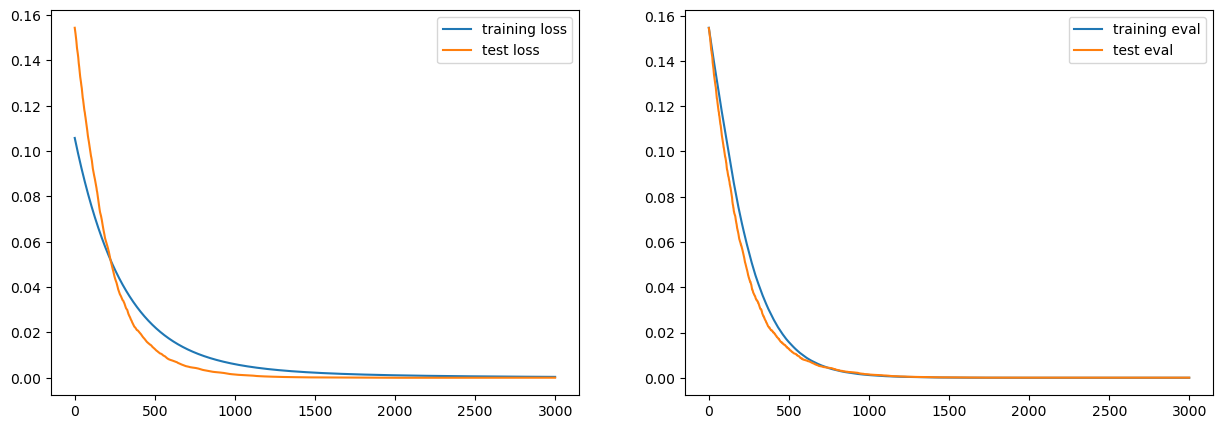

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
stats.iloc[:, :2].plot(ax=axs[0])
stats.iloc[:, 2:].plot(ax=axs[1])

Learned model params:

In [10]:
for name, param in model.named_parameters():
    print(f"{name}:\t{param}")

weight:	Parameter containing:
tensor([[0.2885, 0.5738, 0.8765]], requires_grad=True)
bias:	Parameter containing:
tensor([0.0546], requires_grad=True)


Spearman corr by eyes:

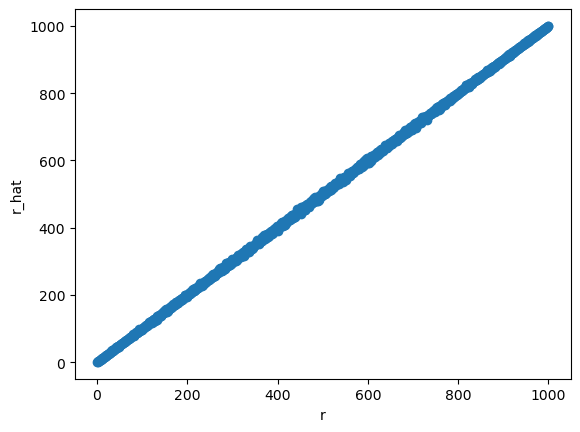

In [11]:
r = rank(y_train)
r_hat = rank(model(X_train))

fig, axs = plt.subplots()
axs.scatter(r, r_hat)
axs.set_xlabel("r")
axs.set_ylabel("r_hat")
plt.show()

In [22]:
model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples)

model, stats = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=3000,
        lr=1e-2,
        weight_decay=0.0,
        loss_fn=loss_msrd,
        eval_fn=eval_spearman
        )

In [23]:
for name, param in model.named_parameters():
    print(f"{name}:\t{param}")

weight:	Parameter containing:
tensor([[0.2885, 0.5738, 0.8765]], requires_grad=True)
bias:	Parameter containing:
tensor([0.0546], requires_grad=True)


<Axes: >

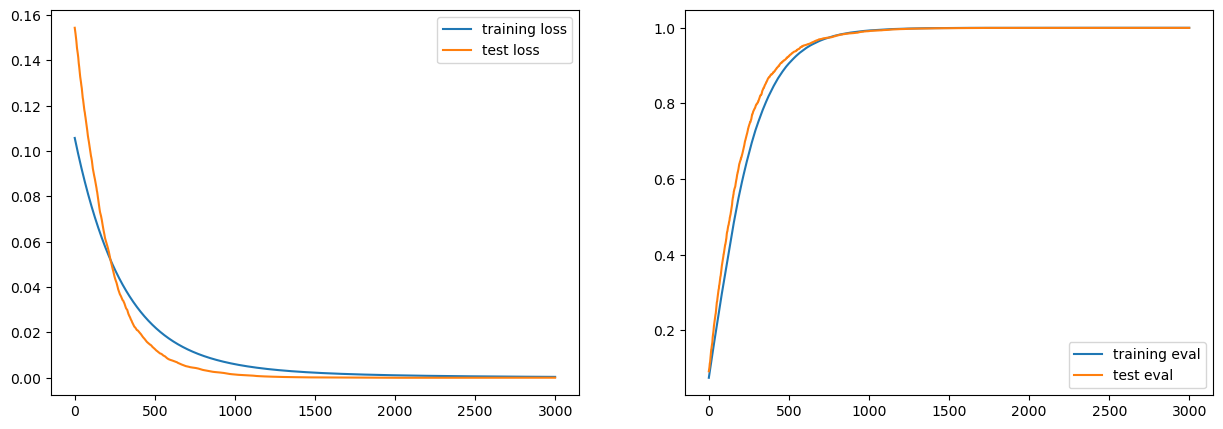

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
stats.iloc[:, :2].plot(ax=axs[0])
stats.iloc[:, 2:].plot(ax=axs[1])